In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split



from paretoset import paretoset
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter
from plots import calculate_failure_rate, drop_frames_without_results, min_max_scaling

import argparse
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

In [2]:
FOLDER = Path("output/plots/")
csv_file = FOLDER / "data.csv"
data = pd.read_csv(csv_file, index_col=0)
data.columns = data.columns.str.strip()
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.def_value.replace("", 0, inplace=True)
data.atk_value.replace("", 0, inplace=True)
data = drop_frames_without_results(data)
data = calculate_failure_rate(data)
data = min_max_scaling(data)
data.dropna(axis=0, subset=['atk_value', 'atk_param'], inplace=True)
data.dropna(axis=0, subset=['def_value', 'def_param'], inplace=True)
# data=data[data['def_gen'] == 'Gauss-in']
# data=data[data['atk_gen'] == 'HSJ']

print(
    "Adversarial Accuracy:", "\n",
    "ResNet152:", data[data['model_layers'] == 152].adv_accuracy.mean(skipna=True), "\n",
    "Resnet101:", data[data['model_layers'] == 101].adv_accuracy.mean(skipna=True), "\n",
    "Resnet50:", data[data['model_layers'] == 50].adv_accuracy.mean(skipna=True), "\n",
    "Resnet34:", data[data['model_layers'] == 34].adv_accuracy.mean(skipna=True), "\n",
    "Resnet18:", data[data['model_layers'] == 18].adv_accuracy.mean(skipna=True), "\n",
)



Adversarial Accuracy: 
 ResNet152: 0.09937931034482758 
 Resnet101: 0.10020833333333334 
 Resnet50: 0.09903225806451614 
 Resnet34: 0.09656 
 Resnet18: 0.08548387096774193 



In [3]:

def plot_aft(
    df,
    file,
    event_col,
    duration_col,
    title,
    mtype,
    xlabel=None,
    ylabel=None,
    replacement_dict={},
    **kwargs,
):
    if mtype == "weibull":
        aft = WeibullAFTFitter(**kwargs)
    elif mtype == "log_normal":
        aft = LogNormalAFTFitter(**kwargs)
    elif mtype == "log_logistic":
        aft = LogLogisticAFTFitter(**kwargs)
    elif mtype == "cox":
        aft = CoxPHFitter(**kwargs)
    assert (
        duration_col in df.columns
    ), f"Column {duration_col} not in dataframe with columns {df.columns}"
    if event_col is not None:
        assert (
            event_col in df.columns
        ), f"Column {event_col} not in dataframe with columns {df.columns}"
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    ax = aft.plot()
    labels = ax.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    plt.show()
    return ax, aft

def plot_partial_effects(
    file,
    aft,
    covariate_array,
    values_array,
    title,
    xlabel="Covariate",
    ylabel="Failure rate",
    legend_kwargs={"loc": "upper left"},
    replacement_dict={},
    cmap='coolwarm',
    **kwargs,     
     ):
    plt.gcf().clear()
    # kwargs.pop("replacement_dict")
    pareto = aft.plot_partial_effects_on_outcome(covariate_array, values_array, cmap=cmap, **kwargs)
    labels = pareto.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    pareto.set_yticklabels(labels)
    pareto.legend(**legend_kwargs)
    pareto.set_ylabel(ylabel)
    pareto.set_xlabel(xlabel)
    pareto.set_title(title)
    pareto.get_figure().tight_layout()
    pareto.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    return pareto

def score_model(aft, train, test):
    train_score = aft.score(train)
    test_score = aft.score(test)
    scores = {'train_score': train_score, 'test_score': test_score}
    plt.show()
    return  scores


def clean_data_for_aft(
    data, kwarg_list, target="adv_failure_rate"
):
    subset = data.copy()
    assert target in subset, f"Target {target} not in dataframe with columns {subset.columns}"
    
    cleaned = pd.DataFrame()
    kwarg_list.append(target)
    for kwarg in kwarg_list:
        cleaned = pd.concat([cleaned, subset[kwarg]], axis=1)
    cols = cleaned.columns
    cleaned = pd.DataFrame(subset, columns=cols)
    
    
    # if "accuracy" in cleaned.columns:
    #     cleaned = cleaned[~cleaned[cleaned['accuracy'] != 1e10]]
    #     cleaned = cleaned[~cleaned[cleaned['accuracy'] != -1e10]]
    # if "adv_accuracy" in cleaned.columns:
    #     cleaned = cleaned[cleaned[cleaned['adv_accuracy'] != 1e10]]
    #     cleaned = cleaned[cleaned[cleaned['adv_accuracy'] != -1e10]]
    cleaned.dropna(inplace=True, how='any', axis=0)
    y = cleaned[target]
    assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"
    return cleaned, y, data

In [4]:


kwarg_list = [
    "accuracy",
    "train_time",
    "predict_time",
    "atk_value",
    "def_value",
    "data.sample.random_state",
    "adv_failure_rate",
    "failure_rate",
    "model_layers",
    "adv_fit_time",
    # "atk_param",
    # "def_param",
    
    "model.art.pipeline.initialize.kwargs.optimizer.lr",
    # "def_gen",
    # "atk_gen",
    # "adv_log_loss",
    # "adv_accuracy",
    # "adv_accuracy",
]


# cleaned['accuracy'] = y

In [5]:
data.loc[:, "adv_failures"] = (1 - data.loc[:, "adv_accuracy"]) * 100
data.loc[:, "ben_failures"] = (1 - data.loc[:, "accuracy"]) * 100
target = "ben_failures"
duration_col = "predict_time"
cleaned, y, data = clean_data_for_aft(data, kwarg_list,  target=target)
X_train, X_test, y_train, y_test = train_test_split(cleaned, y,  test_size=0.2, random_state=42)
assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"




In [6]:

# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='yeo-johnson', standardize=False)
# del X_train[target]
# del X_test[target]
# X_train_cols = X_train.columns
# X_train = pt.fit(X_train).transform(X_train)
# X_test = pt.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=X_train_cols)
# X_test = pd.DataFrame(X_test, columns=X_train_cols)
# X_train[target] = y_train
# y_train = X_train[target]


In [7]:
# sense_dict ={
#     "accuracy" : "max",
#     "train_time" : "min",
#     "predict_time" : "min",
#     # "atk_value" : "diff",
#     # "def_value" : "diff",
#     "data.sample.random_state" : "diff",
#     "adv_accuracy" : "min",
#     "model_layers" : "diff",
#     # "adv_fit_time" : "min",
#     # "atk_param" : "diff",
#     # "def_param" : "diff",
#     "model.art.pipeline.initialize.kwargs.optimizer.lr" : "diff",
#     # "adv_failure_rate" : "maximize",
# }
# subset = X_train.loc[:, sense_dict.keys()]
# senses = sense_dict.values()
# these = paretoset(subset)
# X_train = X_train.iloc[these, :]


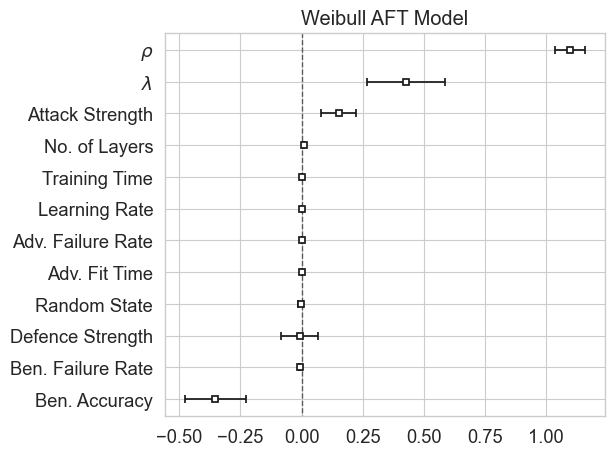

<lifelines.WeibullAFTFitter: fitted with 568 total observations, 0 right-censored observations>
             duration col = 'predict_time'
                event col = 'ben_failures'
   number of observations = 568
number of events observed = 568
           log-likelihood = -723.10
         time fit was run = 2023-09-25 13:54:12 UTC

---
                                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                                 
lambda_ accuracy                                           -0.35       0.70       0.06            -0.48            -0.23                 0.62                 0.80
        adv_failure_rate                                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        adv_fit_time                                       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        atk_value                                           0.15       1.16       0.04             0.08             0.22                 1.08                 1.25
        data.sample.random_state                           -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
        def_value                                          -0.01       0.99       0.04            -0.08             0.07                 0.92                 1.07
        failure_rate                                       -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
        model.art.pipeline.initialize.kwargs.optimizer.lr   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        model_layers                                        0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
        train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Intercept                                           0.43       1.53       0.08             0.27             0.59                 1.31                 1.80
rho_    Intercept                                           1.10       2.99       0.03             1.03             1.16                 2.81                 3.18

                                                            cmp to      z      p   -log2(p)
param   covariate                                                                          
lambda_ accuracy                                              0.00  -5.49 <0.005      24.58
        adv_failure_rate                                      0.00  -1.55   0.12       3.04
        adv_fit_time                                          0.00  -4.43 <0.005      16.67
        atk_value                                             0.00   4.18 <0.005      15.05
        data.sample.random_state                              0.00  -0.83   0.41       1.29
        def_value                                             0.00  -0.21   0.84       0.26
        failure_rate                                          0.00 -10.63 <0.005      85.23
        model.art.pipeline.initialize.kwargs.optimizer.lr     0.00   0.58   0.56       0.84
        model_layers                                          0.00  20.39 <0.005     304.56
        train_time                                            0.00  14.89 <0.005     164.17
        Intercept                                             0.00   5.30 <0.005      23.02
rho_    Intercept                                             0.00  34.56 <0.005     867.25
---
Concordance = 0.87
AIC = 1470.20
log-likelihood ratio test = 1003.22 on 10 df
-log2(p)

In [8]:
weibull_dict = {
    "Intercept: rho_": "$\\rho$",
    "Intercept: lambda_": "$\lambda$",
    "data.sample.random_state: lambda_": "Random State",
    "def_value: lambda_": "Defence Strength",
    "atk_value: lambda_": "Attack Strength",
    "train_time: lambda_": "Training Time",
    "predict_time: lambda_": "Inference Time",
    "adv_accuracy: lambda_": "Adv. Accuracy",
    "accuracy: lambda_": "Ben. Accuracy",
    "adv_fit_time: lambda_": "Adv. Fit Time",
    "adv_log_loss: lambda_": "Adv. Log Loss",
    "adv_failure_rate: lambda_": "Adv. Failure Rate",
    "failure_rate: lambda_": "Ben. Failure Rate",
    "model_layers: lambda_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: lambda_" : "Learning Rate",
    "def_gen" : "Defence",
}

weibull_afr, wft = plot_aft(
    X_train,
    file = "weibull_aft.pdf",
    event_col = target,
    duration_col = duration_col,
    title = "Weibull AFT Model",
    mtype = "weibull",
    replacement_dict=weibull_dict,
)
wft.print_summary()
wft_scores = score_model(wft, X_train, X_test)


/tmp/ipykernel_615644/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


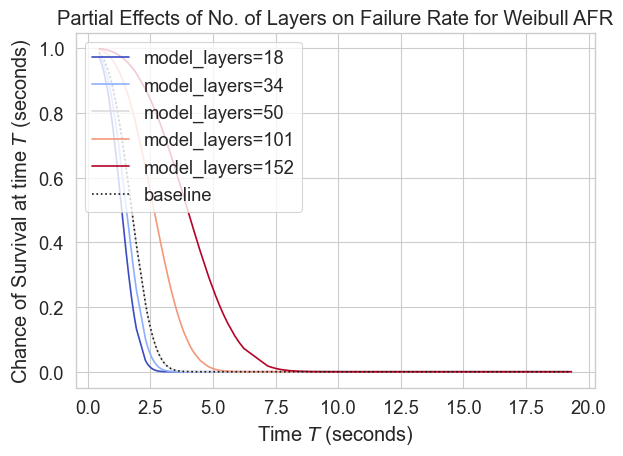

In [9]:
pareto_dict = {
    "model_layers=18": "18",
    "model_layers=34": "34",
    "model_layers=50": "50",
    "model_layers=101": "101",
    "model_layers=152": "152",
}
pareto_weibull = plot_partial_effects(
    file = "weibull_partial_effects.pdf", 
    aft = wft, 
    covariate_array="model_layers", 
    values_array=[18, 34, 50, 101, 152], 
    title="Partial Effects of No. of Layers on Failure Rate for Weibull AFR", 
    replacement_dict=pareto_dict, 
    ylabel="Chance of Survival at time $T$ (seconds)",
    xlabel="Time $T$ (seconds)",
    legend = {"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
    )

# weibull_accuracy = plot_partial_effects(
#     file = "weibull_partial_effect_accuracy.pdf",
#     aft = wft,
#     covariate_array = "accuracy",
#     values_array = [.9, .99, .999, .9999],
#     replacement_dict=weibull_dict,
#     title="Partial Effects of Benign Accuracy on Failure Rate",
#     ylabel="Chance of Survival at time $T$ (seconds)",
#     xlabel="Time $T$ (seconds)",
#     legend = {"title" : "Benign Accuracy"},
#     )
    
    

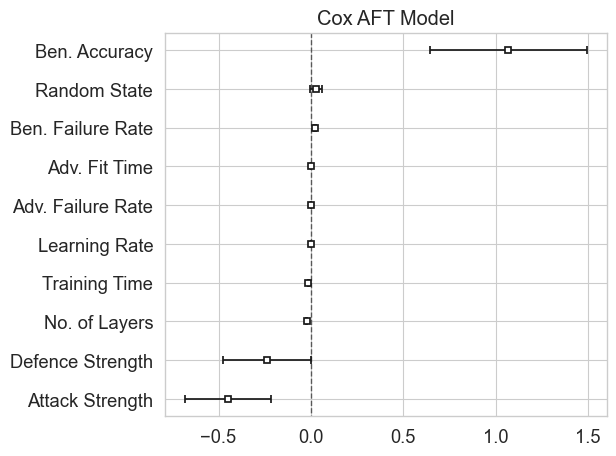

<lifelines.CoxPHFitter: fitted with 568 total observations, 0 right-censored observations>
             duration col = 'predict_time'
                event col = 'ben_failures'
      baseline estimation = breslow
   number of observations = 568
number of events observed = 568
   partial log-likelihood = -2477.41
         time fit was run = 2023-09-25 13:54:14 UTC

---
                                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                 
accuracy                                            1.07       2.91       0.22             0.64             1.49                 1.90                 4.45
train_time                                         -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
atk_value                                          -0.45       0.64       0.12            -0.68            -0.22                 0.51                 0.80
def_value                                          -0.24       0.79       0.12            -0.48             0.00                 0.62                 1.00
data.sample.random_state                            0.03       1.03       0.02            -0.00             0.06                 1.00                 1.06
adv_failure_rate                                    0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
failure_rate                                        0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
model_layers                                       -0.02       0.98       0.00            -0.03            -0.02                 0.98                 0.98
adv_fit_time                                        0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                                    cmp to      z      p   -log2(p)
covariate                                                                          
accuracy                                              0.00   4.93 <0.005      20.23
train_time                                            0.00 -16.43 <0.005     198.99
atk_value                                             0.00  -3.79 <0.005      12.68
def_value                                             0.00  -1.94   0.05       4.27
data.sample.random_state                              0.00   1.82   0.07       3.86
adv_failure_rate                                      0.00   2.82 <0.005       7.70
failure_rate                                          0.00   7.57 <0.005      44.64
model_layers                                          0.00 -15.41 <0.005     175.57
adv_fit_time                                          0.00   3.01 <0.005       8.60
model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  -0.83   0.41       1.29
---
Concordance = 0.90
Partial AIC = 4974.82
log-likelihood ratio test = 1122.01 on 10 df
-log2(p) of ll-ratio test = 777.41

/tmp/ipykernel_615644/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


<Figure size 640x480 with 0 Axes>

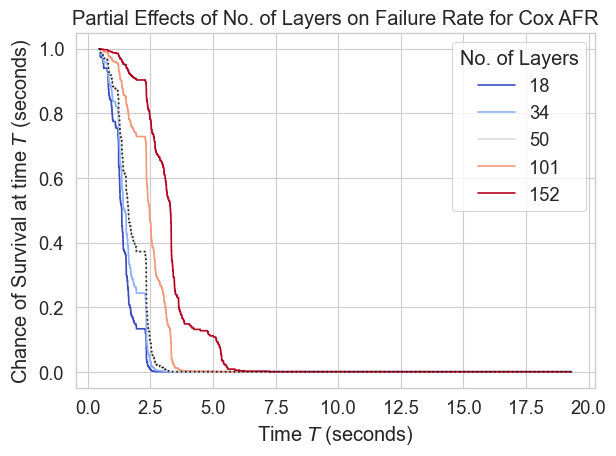

In [10]:

cox_dict = {
    "adv_failure_rate": "Adv. Failure Rate",
    "def_value" : "Defence Strength",
    "data.sample.random_state" : "Random State",
    "train_time" : "Training Time",
    "model_layers" : "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_accuracy" : "Adv. Accuracy",
    "adv_fit_time" : "Adv. Fit Time",
    "adv_log_loss" : "Adv. Log Loss",
    "predict_time" : "Inference Time",
    "accuracy" : "Ben. Accuracy",
    "failure_rate" : "Ben. Failure Rate",
    "atk_value" : "Attack Strength",
}

cox_afr, cft = plot_aft(
    X_train,
    file = "cox_aft.pdf",
    event_col = target,
    duration_col = duration_col,
    title = "Cox AFT Model",
    mtype = "cox",
    replacement_dict=cox_dict,
)
cox_scores = score_model(cft, X_train, X_test)
cft.print_summary()
cox_partial = plot_partial_effects(
    file = "cox_partial_effects.pdf",
    aft = cft,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=cox_dict,
    title="Partial Effects of No. of Layers on Failure Rate for Cox AFR",
    ylabel="Chance of Survival at time $T$ (seconds)",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
)

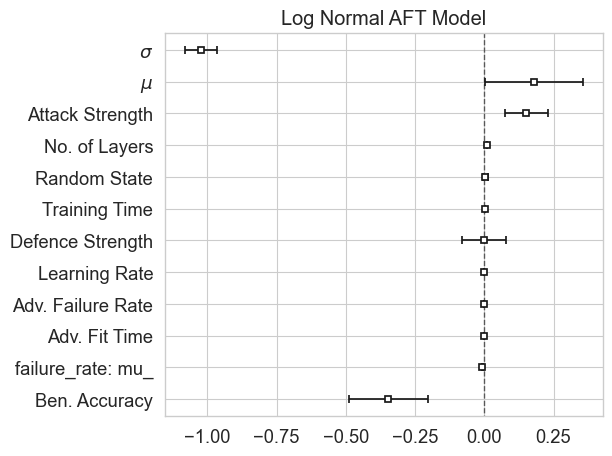

<lifelines.LogNormalAFTFitter: fitted with 568 total observations, 0 right-censored observations>
             duration col = 'predict_time'
                event col = 'ben_failures'
   number of observations = 568
number of events observed = 568
           log-likelihood = -688.89
         time fit was run = 2023-09-25 13:54:16 UTC

---
                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                                 
mu_    accuracy                                           -0.35       0.71       0.07            -0.49            -0.20                 0.61                 0.81
       adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       adv_fit_time                                       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       atk_value                                           0.15       1.16       0.04             0.08             0.23                 1.08                 1.26
       data.sample.random_state                            0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
       def_value                                           0.00       1.00       0.04            -0.08             0.08                 0.92                 1.08
       failure_rate                                       -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
       model.art.pipeline.initialize.kwargs.optimizer.lr   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       model_layers                                        0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
       train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                                           0.18       1.20       0.09             0.00             0.36                 1.00                 1.43
sigma_ Intercept                                          -1.02       0.36       0.03            -1.08            -0.97                 0.34                 0.38

                                                           cmp to      z      p   -log2(p)
param  covariate                                                                          
mu_    accuracy                                              0.00  -4.77 <0.005      19.08
       adv_failure_rate                                      0.00  -2.38   0.02       5.85
       adv_fit_time                                          0.00  -3.90 <0.005      13.35
       atk_value                                             0.00   3.92 <0.005      13.48
       data.sample.random_state                              0.00   0.70   0.48       1.05
       def_value                                             0.00   0.01   0.99       0.01
       failure_rate                                          0.00  -7.22 <0.005      40.82
       model.art.pipeline.initialize.kwargs.optimizer.lr     0.00   0.74   0.46       1.13
       model_layers                                          0.00  28.07 <0.005     573.57
       train_time                                            0.00  26.65 <0.005     517.55
       Intercept                                             0.00   1.99   0.05       4.42
sigma_ Intercept                                             0.00 -34.53 <0.005     865.57
---
Concordance = 0.86
AIC = 1401.78
log-likelihood ratio test = 937.90 on 10 df
-log2(p) of ll-ratio test = 645.63

/tmp/ipykernel_615644/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


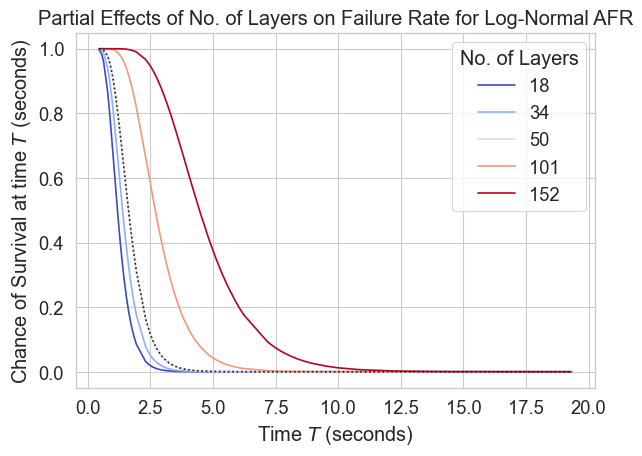

In [11]:
log_normal_dict = {
    "Intercept: sigma_": "$\sigma$",
    "Intercept: mu_": "$\mu$",
    "def_value: mu_": "Defence Strength",
    "atk_value: mu_": "Attack Strength",
    "train_time: mu_": "Training Time",
    "predict_time: mu_": "Inference Time",
    "adv_fit_time: mu_": "Adv. Fit Time",
    "model_layers: mu_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: mu_" : "Learning Rate",
    "data.sample.random_state: mu_": "Random State",
    "adv_log_loss: mu_": "Adv. Log Loss",
    "adv_accuracy: mu_": "Adv. Accuracy",
    "accuracy: mu_": "Ben. Accuracy",
    "adv_failure_rate: mu_": "Adv. Failure Rate",
    "def_gen" : "Defence",
    "learning_rate: mu_" : "Learning Rate",
}

log_normal_graph, lnt = plot_aft(
    X_train,
    "log_normal_aft.pdf",
    target,
    duration_col,
    "Log Normal AFT Model",
    "log_normal",
    replacement_dict=log_normal_dict,
)
lnt_scores = score_model(lnt, X_train, X_test)
lnt.print_summary()
lnt_partial = plot_partial_effects(
    file = "log_normal_partial_effects.pdf",
    aft = lnt,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=log_normal_dict,
    title="Partial Effects of No. of Layers on Failure Rate for Log-Normal AFR",
    ylabel="Chance of Survival at time $T$ (seconds)",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
)

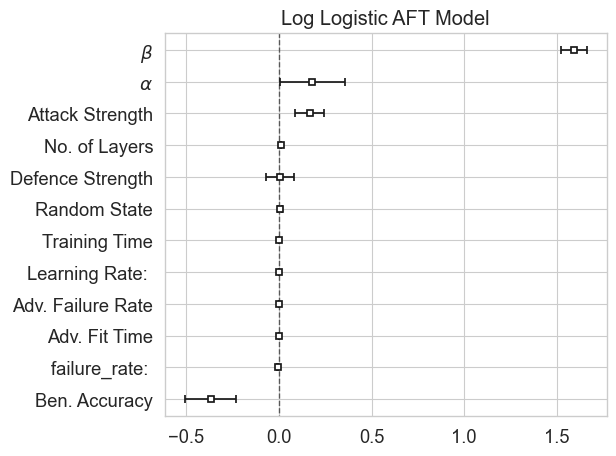

<lifelines.LogLogisticAFTFitter: fitted with 568 total observations, 0 right-censored observations>
             duration col = 'predict_time'
                event col = 'ben_failures'
   number of observations = 568
number of events observed = 568
           log-likelihood = -693.57
         time fit was run = 2023-09-25 13:54:18 UTC

---
                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                                 
alpha_ accuracy                                           -0.37       0.69       0.07            -0.51            -0.23                 0.60                 0.80
       adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       adv_fit_time                                       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       atk_value                                           0.17       1.18       0.04             0.09             0.24                 1.09                 1.28
       data.sample.random_state                            0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
       def_value                                           0.01       1.01       0.04            -0.07             0.08                 0.93                 1.09
       failure_rate                                       -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
       model.art.pipeline.initialize.kwargs.optimizer.lr   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       model_layers                                        0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
       train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                                           0.18       1.20       0.09             0.00             0.36                 1.00                 1.43
beta_  Intercept                                           1.59       4.91       0.04             1.52             1.66                 4.58                 5.26

                                                           cmp to     z      p   -log2(p)
param  covariate                                                                         
alpha_ accuracy                                              0.00 -5.18 <0.005      22.07
       adv_failure_rate                                      0.00 -2.58   0.01       6.64
       adv_fit_time                                          0.00 -3.93 <0.005      13.55
       atk_value                                             0.00  4.20 <0.005      15.17
       data.sample.random_state                              0.00  1.13   0.26       1.96
       def_value                                             0.00  0.16   0.87       0.20
       failure_rate                                          0.00 -7.72 <0.005      46.29
       model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  0.55   0.58       0.78
       model_layers                                          0.00 25.06 <0.005     458.04
       train_time                                            0.00 15.51 <0.005     177.74
       Intercept                                             0.00  2.00   0.05       4.44
beta_  Intercept                                             0.00 45.13 <0.005        inf
---
Concordance = 0.86
AIC = 1411.15
log-likelihood ratio test = 942.02 on 10 df
-log2(p) of ll-ratio test = 648.58

{'train_score': -1.221079966573897, 'test_score': -1.0974447812062609}


/tmp/ipykernel_615644/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


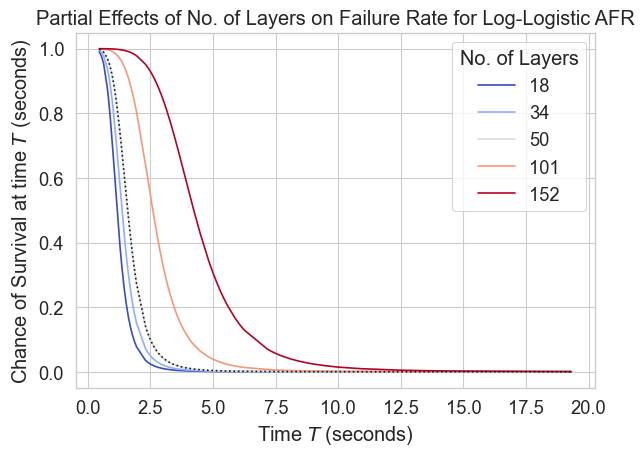

In [12]:

log_logistic_dict = {
    "Intercept: beta_": "$\\beta$",
    "Intercept: alpha_": "$\\alpha$",
    "data.sample.random_state: alpha_": "Random State",
    "def_value: alpha_": "Defence Strength",
    "atk_value: alpha_": "Attack Strength",
    "train_time: alpha_": "Training Time",
    "predict_time: alpha_": "Inference Time",
    "adv_accuracy: alpha_": "Adv. Accuracy",
    "accuracy: alpha_": "Ben. Accuracy",
    "adv_fit_time: alpha_": "Adv. Fit Time",
    "model_layers: alpha_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_failure_rate: alpha_": "Adv. Failure Rate",
    "alpha_" : "",

}

log_logistic_graph, llt = plot_aft(
    X_train,
    "log_logistic_aft.pdf",
    target,
    duration_col,
    "Log Logistic AFT Model",
    "log_logistic",
    replacement_dict=log_logistic_dict,
)
llt.print_summary()
llt_scores = score_model(llt, X_train, X_test)
print(llt_scores)
llt_partial = plot_partial_effects(
    file = "log_logistic_partial_effects.pdf",
    aft = llt,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=log_logistic_dict,
    title="Partial Effects of No. of Layers on Failure Rate for Log-Logistic AFR",
    ylabel="Chance of Survival at time $T$ (seconds)",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
       
)

In [13]:
np.mean(llt.predict_median(X_train))

3.151203500424281

In [53]:
aft_dict = {
    "Weibull": wft,
    "LogNormal": lnt,
    "LogLogistic": llt,
    # "Cox": cft,
}

score_list = [
    wft_scores,
    lnt_scores,
    llt_scores,
    # cft_scores,
]
aft_data = pd.DataFrame()
aft_data.index.name = "Model"
aft_data.index = aft_dict.keys()
aft_data["AIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values() ]
# aft_data["LogLikelihood"] = [x.log_likelihood_ for x in aft_dict.values()]
aft_data["Concordance Score"] = [x.concordance_index_ for x in aft_dict.values()]
aft_data["BIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values()]
# aft_data['Train Log Likelihood'] = [x['train_score'] for x in score_list]
# aft_data['Test Log Likelihood'] = [x['test_score'] for x in score_list]
aft_data['Estimated Mean Survival Time'] = [x.predict_expectation(X_train).mean() for x in aft_dict.values()]
# aft_data['True Mean Survival Time'] = (1 / (y_train/X_train[duration_col])).mean()
aft_data['Estimated Median Survival Time'] = [x.predict_median(X_train).median() for x in aft_dict.values()]
# aft_data['True Median Survival Time'] = (1 - (y_train/X_train[duration_col])).median()
success_rate = X_train['accuracy']
aft_data['True Mean Survival Time'] = ((1/X_train.accuracy).replace(np.inf, np.nan) * X_train.predict_time).mean()
aft_data['True Median Survival Time'] = ((1/X_train.accuracy).replace(np.inf, np.nan) * X_train.predict_time).median()
aft_data['Predicted Error from True Mean'] = aft_data['Estimated Mean Survival Time'] - aft_data['True Mean Survival Time']
aft_data['Predicted Error from True Median'] = aft_data['Estimated Median Survival Time'] - aft_data['True Median Survival Time']
del aft_data['True Mean Survival Time']
del aft_data['True Median Survival Time']
aft_data = aft_data.round(2)
aft_data.to_csv(FOLDER / "aft_comparison.csv")
logger.info(f"Saved AFT comparison to {FOLDER / 'aft_comparison.csv'}")
aft_data.round(2).to_latex(FOLDER / "aft_comparison.tex")
aft_data.round(2)



,AIC,Concordance Score,BIC,Estimated Mean Survival Time,Estimated Median Survival Time,Predicted Error from True Mean,Predicted Error from True Median
Weibull,1470.20,0.87,1470.20,7.34,2.16,0.19,-1.14
LogNormal,1401.78,0.86,1401.78,3.39,1.94,-3.76,-1.36
LogLogistic,1411.15,0.86,1411.15,3.38,1.99,-3.78,-1.31
